In [1]:
import arviz as az
import bambi as bmb
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")
np.random.seed(1211)

#### Code 6.1

In [3]:
np.random.seed(3)
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

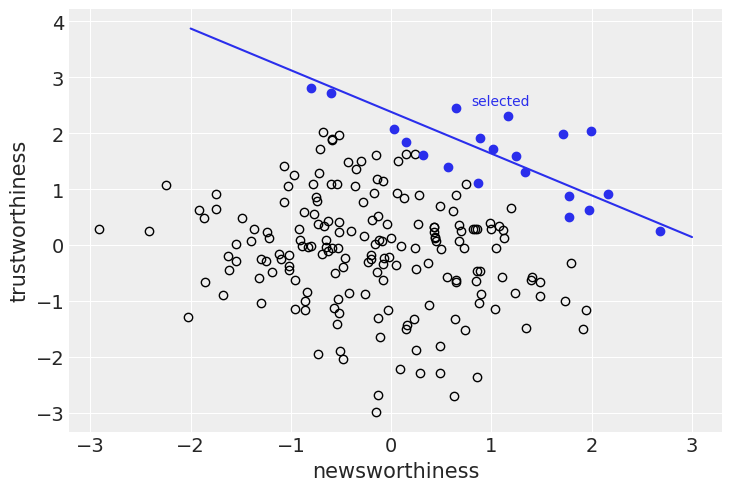

In [4]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness");

#### Code 6.2

In [5]:
N = 100                                                       # number of individuals
height = np.random.normal(10, 2, N)                           # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)                     # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)   # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

# combine into data frame
d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  
d.head()

,height,leg_left,leg_right
0,10.178107,4.206429,4.158048
1,11.557794,4.769875,4.825845
2,12.529290,5.543952,5.529080
3,8.238977,3.853735,3.801846
4,10.472811,4.333044,4.290579


#### Code 6.3

In [6]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=10, sd=100),
    "leg_left": bmb.Prior("Normal", mu=2, sd=10),
    "leg_right": bmb.Prior("Normal", mu=2, sd=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_1 = bmb.Model("height ~ leg_left + leg_right", d, priors=priors)
results_6_1 = model_6_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, leg_right, leg_left, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 71 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
az.summary(results_6_1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,0.985,0.329,0.368,1.598
leg_left,-1.851,2.310,-6.599,2.121
leg_right,3.876,2.303,-0.236,8.466
height_sigma,0.646,0.044,0.574,0.739


Note the heigh variability in the estimates and the lack of consistency with the results in the book in terms of point estimates... This is because of the multicollinearity!!

#### Code 6.4

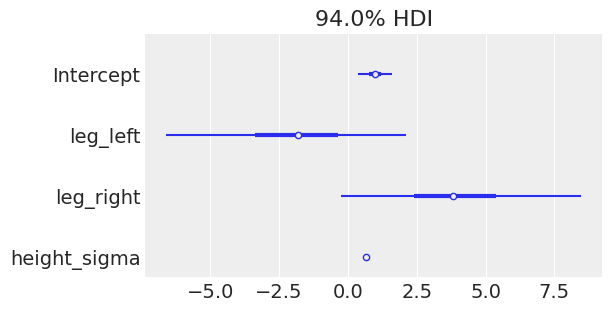

In [8]:
az.plot_forest(results_6_1, combined=True, figsize=[6, 3]);

#### Code 6.5 and 6.6

In [9]:
# Grab samples from the posteriors
leg_left = results_6_1.posterior["leg_left"].values.flatten()
leg_right = results_6_1.posterior["leg_right"].values.flatten()

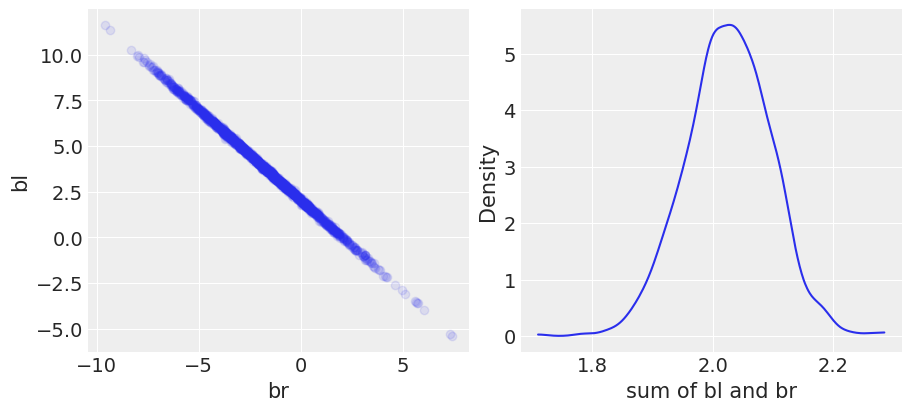

In [10]:
fig, ax = plt.subplots(1, 2, figsize=[9, 4])

# code 6.5
ax[0].scatter(leg_left, leg_right, alpha=0.1)
ax[0].set_xlabel("br")
ax[0].set_ylabel("bl")

# code 6.6
az.plot_kde(leg_left + leg_right, ax=ax[1])
ax[1].set_ylabel("Density")
ax[1].set_xlabel("sum of bl and br");

#### Code 6.7

In [11]:
# We remove the prior for the 'leg_right' variable
priors.pop("leg_right")
model_6_2 = bmb.Model("height ~ leg_left", d, priors=priors)
results_6_2 = model_6_2.fit()
az.summary(results_6_2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, leg_left, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7061828650088336, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%
Intercept,0.905,0.344,0.220,1.513
leg_left,2.037,0.074,1.900,2.183
height_sigma,0.651,0.047,0.565,0.738


#### Code 6.8

We define standardize again

In [12]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [13]:
d = pd.read_csv("data/milk.csv")
d["K"] = standardize(d["kcal.per.g"])
d["F"] = standardize(d["perc.fat"])
d["L"] = standardize(d["perc.lactose"])

#### Code 6.9

In [14]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2),
    "F": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_3 = bmb.Model("K ~ F", d, priors=priors)
results_6_3 = model_6_3.fit()

priors["L"] = bmb.Prior("Normal", mu=0, sd=0.5)
model_6_4 = bmb.Model("K ~ L", d, priors=priors)
results_6_4 = model_6_4.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, F, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, L, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [15]:
az.summary(results_6_3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-0.000,0.086,-0.155,0.170
F,0.858,0.094,0.682,1.033
K_sigma,0.495,0.070,0.372,0.627


In [16]:
az.summary(results_6_4, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-0.002,0.074,-0.142,0.136
L,-0.898,0.078,-1.045,-0.752
K_sigma,0.420,0.061,0.316,0.540


#### Code 6.10

In [17]:
model_6_5 = bmb.Model("K ~ F + L", d, priors=priors)
results_6_5 = model_6_5.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, L, F, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


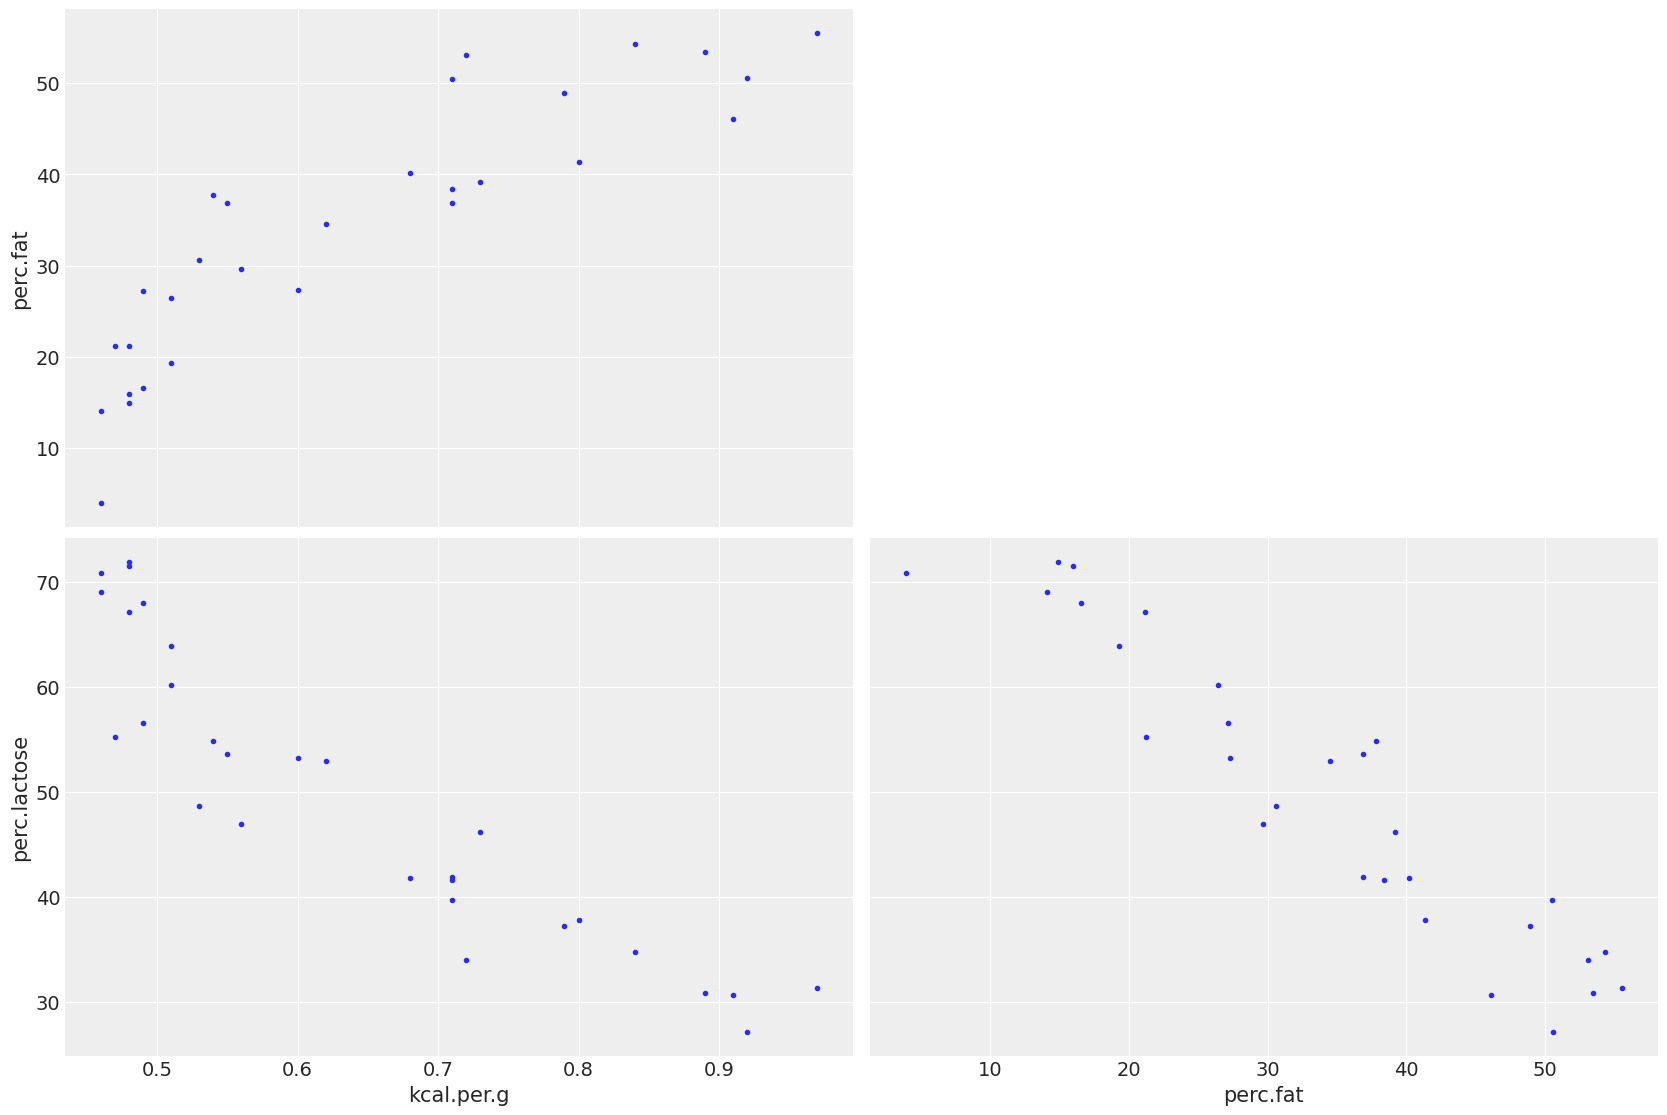

In [18]:
az.plot_pair(d[["kcal.per.g", "perc.fat", "perc.lactose"]].to_dict("list"));

In [19]:
%watermark -n -u -v -iv -w

Last updated: Tue Apr 27 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

arviz     : 0.11.2
json      : 2.0.9
numpy     : 1.20.2
matplotlib: 3.4.1
daft      : 0.1.2
scipy     : 1.6.2
pandas    : 1.2.4
bambi     : 0.4.1

Watermark: 2.2.0

